In [1]:
import glob
import os
from lsst import afw
#print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_ITL, plotonesensor_ITL_smooth, create_combined_ITL, internaladjustment
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+5


In [2]:
# looking at Raft 13, CCD 21, run 10982 (must be a good run) .... same as in testing_making_flat_from_lamda notebook and combined_CCOB_full_sensor_flat

superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)

[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{B}$')

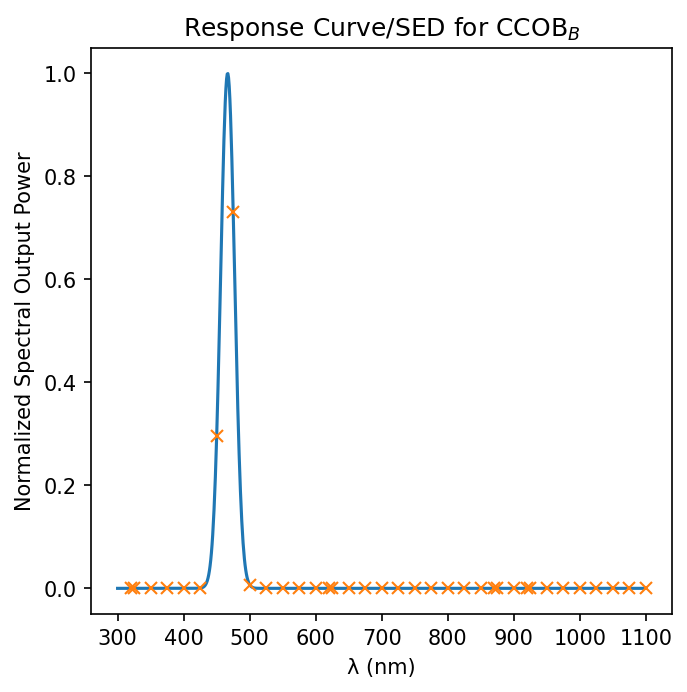

In [3]:
# response function at BLUE band using LSST filters, not SDSS
# x and y functions are a numpy.array , they replace the sdssfilter[2].data["wavelength"] and sdssfilter[2].data["respt"] respectively


fig, axs = pylab.subplots(figsize=(5,5),dpi=150)

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)

# want to use the BLUE band, so the second element in each list
mu = wavelengths_list[1]
sigma = width_of_wavelength_list_converted[1]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
         # gaussians #
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
# plots the gaussians
pylab.plot(x, y)

weights = numpy.interp(wls, x, y)    
# plots 'x's
pylab.plot(wls, weights,"x")

# labeling plot
pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{B}$")

In [4]:
def create_ccob(img_list):
    num_ch = 16    
    blue_arr = [None] * num_ch
    normedimg_arr = [None] * num_ch
    MEDIAN = None

    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/fits/QE_R02_S21_blue_-211.815_-0.395.fits"     
    ccob_blue = get_ccd_from_id(None, fname, [])

    for ch in range(num_ch):    
        blue = get_data_as_read(ccob_blue,ch + 1,["imaging"])["imaging"]    # QE data array for CCOBb flat field image
        MEDIAN = numpy.median(blue)                                        # median (not mean, avoiding outliers) of QE data array for CCOBb, will normalize COMBINED with this
        normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
        normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
        blue_arr[ch] = blue  
    return normedimg_arr, blue_arr

In [5]:
title = "COMBINED not normalized R02_S21"
img_list = create_combined_ITL(superdarkpath, superbiaspath, qeflatpath, weights, title)    # create_combined returns img_list at end of function
create_ccob(img_list)
print('')

[1.         0.99991465 0.99746612 1.00045723 1.00086964 1.00415552
 1.00289479 1.00279658 1.00561587 1.01074357 1.00637592 1.00659691
 1.00879283 1.00894868 1.00876719 1.00788981]
[1.         0.99991465 0.99746612 1.00045723 1.00086964 1.00415552
 1.00289479 1.00279658 1.00032826 1.00542899 1.00108432 1.00130414
 1.00348851 1.00364355 1.003463   1.00259024]


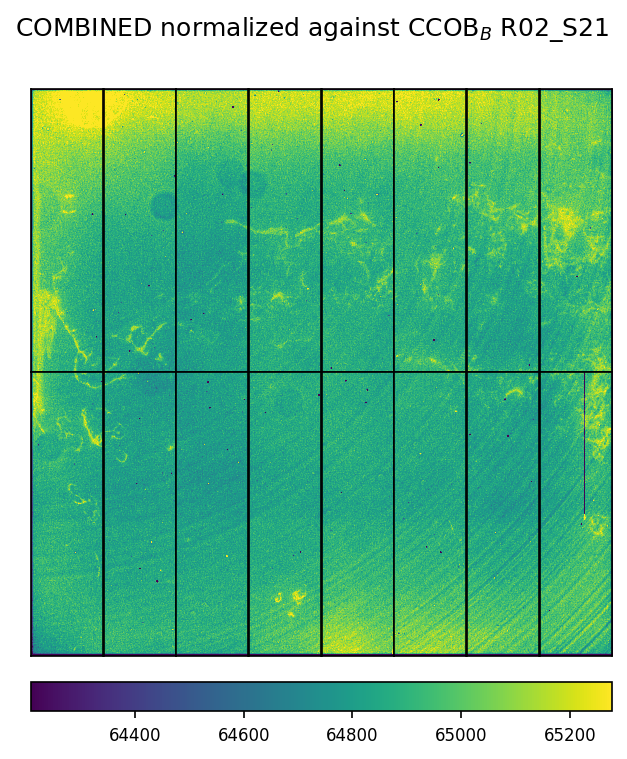

[1.         0.99991465 0.99746612 1.00045723 1.00086964 1.00415552
 1.00289479 1.00279658 1.00561587 1.01074357 1.00637592 1.00659691
 1.00879283 1.00894868 1.00876719 1.00788981]
[1.         0.99975389 0.99718294 0.99973349 0.99962468 1.00221222
 1.00021009 0.99931345 1.00094955 1.00557377 1.00105105 1.00088064
 1.00285148 1.0029293  1.00278942 1.001145  ]
[1.         0.99975389 0.99718294 0.99973349 0.99962468 1.00221222
 1.00021009 0.99931345 1.00089991 1.0055239  1.00100141 1.00083101
 1.00280175 1.00287957 1.00273969 1.00109536]


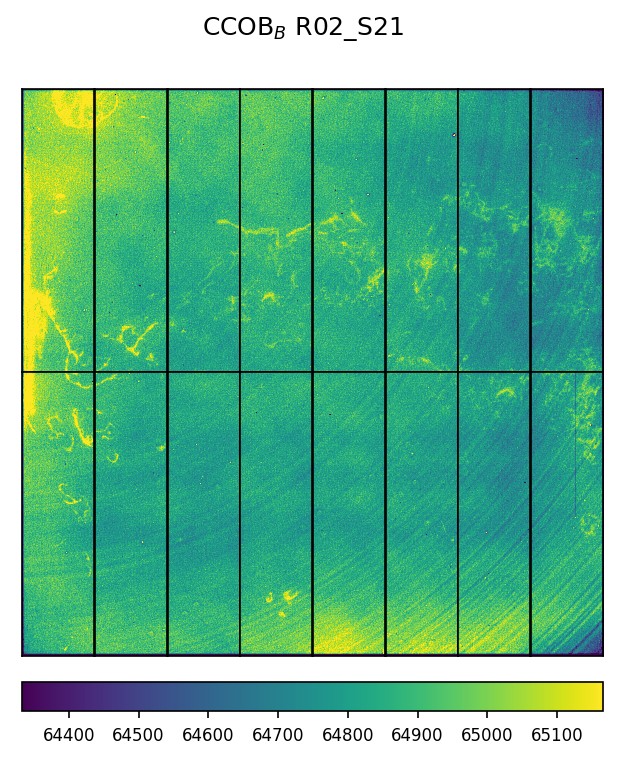

[1.         0.99975389 0.99718294 0.99973349 0.99962468 1.00221222
 1.00021009 0.99931345 1.00094955 1.00557377 1.00105105 1.00088064
 1.00285148 1.0029293  1.00278942 1.001145  ]
[1.         1.00016079 1.00028397 1.00072393 1.00124543 1.00193901
 1.00268414 1.00348552 0.99942887 0.99990561 1.00008282 1.00047273
 1.00068485 1.00076178 1.00072134 1.00149325]


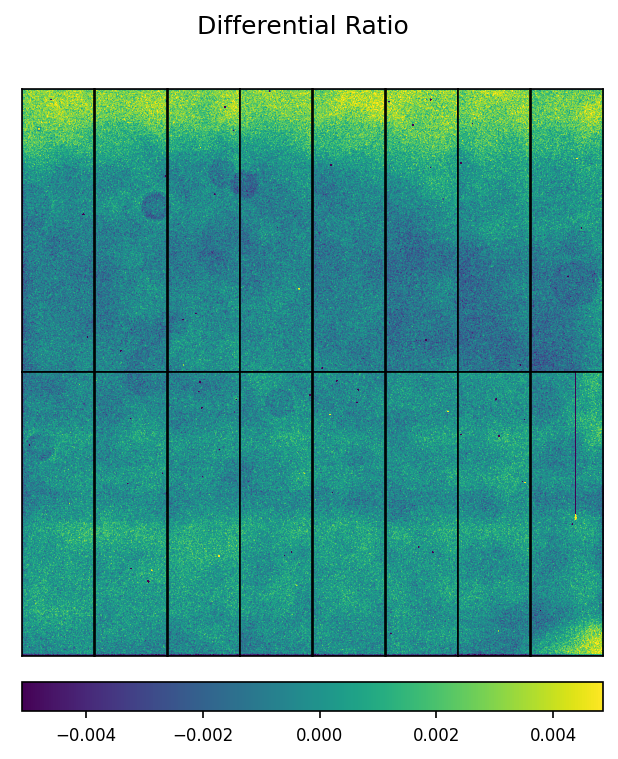

In [6]:
# default color map
num_ch = 16
normedimg_arr, blue_arr = create_ccob(img_list)

# plot normalized, COMBINED flat
image_com = plotonesensor_ITL(normedimg_arr, 'COMBINED normalized against CCOB$_{B}$ R02_S21')
com_relnorm = internaladjustment(image_com)

# plot CCOBred flat
image_com = plotonesensor_ITL(blue_arr, 'CCOB$_{B}$ R02_S21')
ccob_relnorm = internaladjustment(image_com)

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - blue_arr[i]) / blue_arr[i]
plotonesensor_ITL(diff_arr, 'Differential Ratio', relativenorm=com_relnorm/ccob_relnorm)
print()

[1.         0.99991465 0.99746612 1.00045723 1.00086964 1.00415552
 1.00289479 1.00279658 1.00561587 1.01074357 1.00637592 1.00659691
 1.00879283 1.00894868 1.00876719 1.00788981]
[1.         0.99991465 0.99746612 1.00045723 1.00086964 1.00415552
 1.00289479 1.00279658 1.00032826 1.00542899 1.00108432 1.00130414
 1.00348851 1.00364355 1.003463   1.00259024]


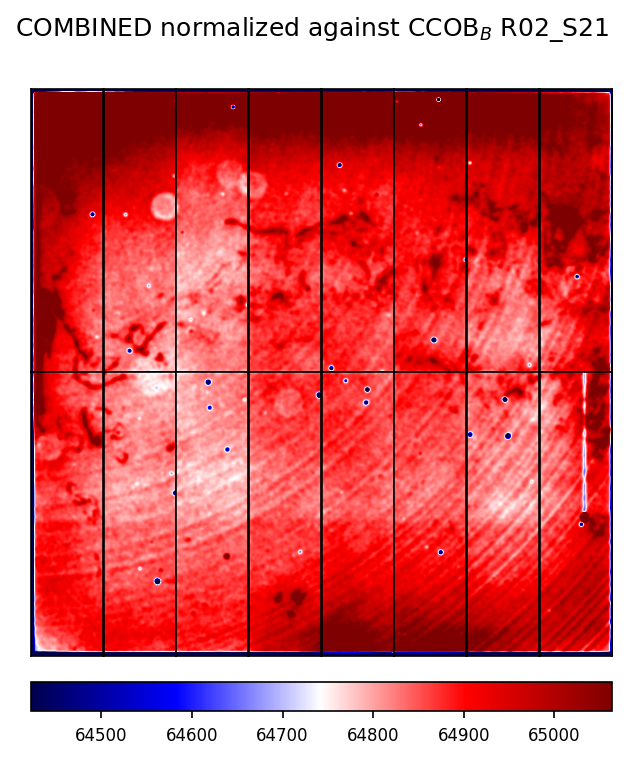

[1.         0.99991465 0.99746612 1.00045723 1.00086964 1.00415552
 1.00289479 1.00279658 1.00561587 1.01074357 1.00637592 1.00659691
 1.00879283 1.00894868 1.00876719 1.00788981]
[1.         0.99975389 0.99718294 0.99973349 0.99962468 1.00221222
 1.00021009 0.99931345 1.00094955 1.00557377 1.00105105 1.00088064
 1.00285148 1.0029293  1.00278942 1.001145  ]
[1.         0.99975389 0.99718294 0.99973349 0.99962468 1.00221222
 1.00021009 0.99931345 1.00089991 1.0055239  1.00100141 1.00083101
 1.00280175 1.00287957 1.00273969 1.00109536]


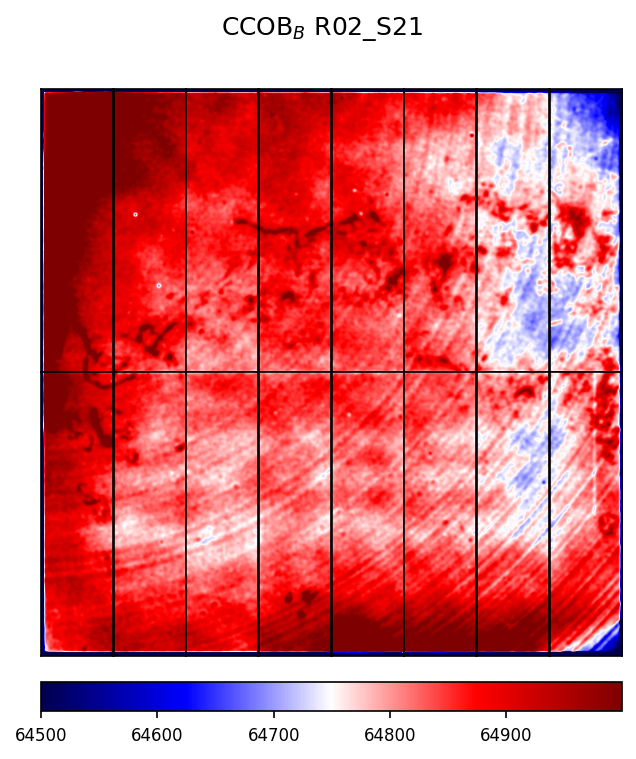

[1.         0.99975389 0.99718294 0.99973349 0.99962468 1.00221222
 1.00021009 0.99931345 1.00094955 1.00557377 1.00105105 1.00088064
 1.00285148 1.0029293  1.00278942 1.001145  ]
[1.         1.00016079 1.00028397 1.00072393 1.00124543 1.00193901
 1.00268414 1.00348552 0.99942887 0.99990561 1.00008282 1.00047273
 1.00068485 1.00076178 1.00072134 1.00149325]


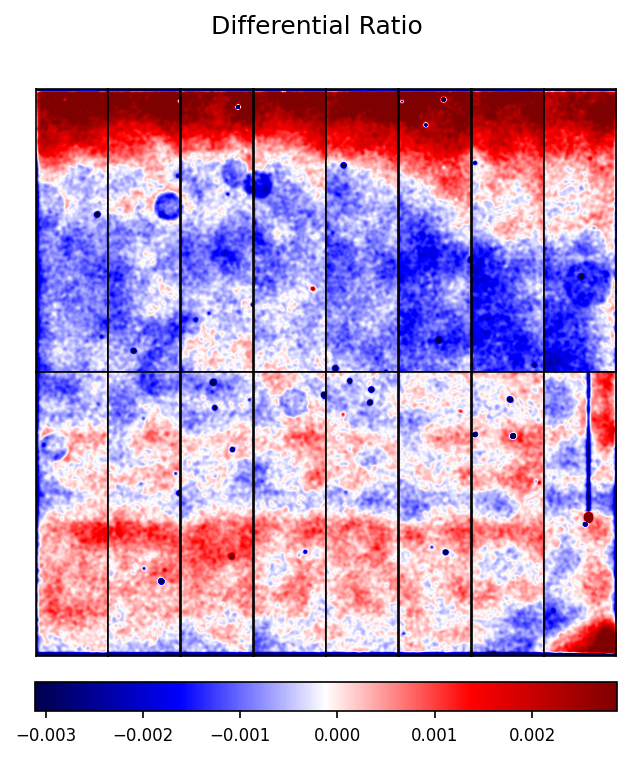

In [7]:
# smoothed color map

# plot normalized, COMBINED flat
image_com = plotonesensor_ITL_smooth(normedimg_arr, 'COMBINED normalized against CCOB$_{B}$ R02_S21')
com_relnorm = internaladjustment(image_com)

# plot CCOBred flat
image_com = plotonesensor_ITL_smooth(blue_arr, 'CCOB$_{B}$ R02_S21')
ccob_relnorm = internaladjustment(image_com)

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - blue_arr[i]) / blue_arr[i]
plotonesensor_ITL_smooth(diff_arr, 'Differential Ratio', relativenorm=com_relnorm/ccob_relnorm)
print()